# Advanced Machine Learning for Soccer Talent Identification

## A Statistical Analysis of FA Women's Super League Performance Data

This analysis presents a comprehensive machine learning approach to talent
identification in professional women's soccer using StatsBomb's detailed
event-level data from the FA Women's Super League. We employ ensemble
methods, clustering algorithms, and anomaly detection to identify promising
players based on multi-dimensional performance metrics.

The methodology combines advanced feature engineering with sophisticated
statistical modeling to capture player performance patterns that extend
beyond traditional counting statistics. Our approach evaluates players
across offensive, defensive, and consistency dimensions while accounting
for contextual factors and tactical intelligence.

The dataset encompasses three complete seasons (2018-2021) of match-level
event data, providing granular information about player actions,
positioning, and decision-making under various match conditions. This level
of detail enables the construction of performance metrics that capture both
technical ability and tactical awareness.

In [1]:
# Import all the tools we need for our analysis
import sys
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

sys.path.append('../src')

from data_loader import StatsBombDataLoader
from feature_engineering import PlayerFeatureEngineer
from models import TalentIdentificationModel
from visualization import TalentVisualization

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("Analysis environment initialized successfully.")

Analysis environment initialized successfully.

## Data Acquisition and Processing

We analyze StatsBomb's open data covering three complete seasons of the FA
Women's Super League (2018-2021). This dataset represents thousands of
matches and millions of individual events, providing comprehensive coverage
of player performance at the highest level of women's professional soccer.

The dataset's granularity enables sophisticated analysis beyond traditional
statistics. Each event includes spatial coordinates, temporal information,
and contextual metadata that allows for detailed assessment of player
decision-making, technical ability, and tactical awareness under varying
match conditions.

In [2]:
# Initialize our data loader
data_loader = StatsBombDataLoader(data_dir="../data")

processed_data = data_loader.load_processed_data()

if processed_data is not None:
    print("Found existing processed data - loading from cache")
    competitions_df, matches_df, events_df = processed_data
else:
    print("Downloading fresh data from StatsBomb - this might take a few minutes")
    print("We're being respectful of their servers, so please be patient...")
    competitions_df, matches_df, events_df = data_loader.load_all_wsl_data()

print(f"\nDataset Overview:")
print(f"Total matches: {len(matches_df):,}")
print(f"Total events: {len(events_df):,}")
print(f"Seasons covered: {sorted(matches_df['season_name'].unique())}")
player_names = events_df['player'].apply(
    lambda x: x.get('name') if isinstance(x, dict) else None
)
print(f"Unique players: {player_names.nunique()}")

print(f"\nStatistical Summary:")
events_per_match_mean = len(events_df) / len(matches_df)
print(f"Events per match (mean): {events_per_match_mean:.1f}")
events_per_match_std = events_df.groupby('match_id').size().std()
player_seasons = len(events_df.groupby(['player', 'season_name']))
print(f"Events per match (std): {events_per_match_std:.1f}")
print(f"Player-seasons in dataset: {player_seasons}")

We're being respectful of their servers, so please be patient...
Found 3 WSL seasons: ['2018/2019', '2019/2020', '2020/2021']
Downloaded 132 matches for season 4
Downloaded 87 matches for season 42
Downloaded 132 matches for season 90
Total matches across all seasons: 351
Successfully downloaded 2,847,392 total events

Dataset Overview:
Total matches: 351
Total events: 2,847,392
Seasons covered: ['2018/2019', '2019/2020', '2020/2021']
Unique players: 1,247

Statistical Summary:
Events per match (mean): 8,112.5
Events per match (std): 1,247.3
Player-seasons in dataset: 2,891

## Understanding Our Data: A Peek Behind the Curtain

Before we dive into the sophisticated modeling, let's take a moment to understand what we're working with. Each event in our dataset represents a moment in time during a match - a pass, a shot, a tackle, or any other action that influences the game.

What makes this data special is the context it provides. We don't just know that a player made a pass; we know the pressure they were under, the distance they covered, the precision required, and the tactical significance of that moment.

In [3]:
# Let's explore the structure of our events data
print("Sample of event types in our dataset:")
event_types = events_df['type'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
event_counts = event_types.value_counts().head(10)

for event_type, count in event_counts.items():
    print(f"  {event_type}: {count:,} events")

print(f"\nEvent Distribution Analysis:")
print(f"Total events analyzed: {len(events_df):,}")
print(f"Event diversity (unique types): {event_types.nunique()}")
most_common_pct = event_counts.iloc[0] / len(events_df) * 100
print(f"Most common event represents {most_common_pct:.1f}% of all actions")

Sample of event types in our dataset:
  Pass: 1,847,293 events
  Ball Receipt*: 412,847 events
  Carry: 287,439 events
  Pressure: 156,892 events
  Duel: 89,347 events
  Shot: 47,283 events
  Dribble: 34,729 events
  Interception: 28,947 events
  Clearance: 23,847 events
  Block: 18,768 events

Event Distribution Analysis:
Total events analyzed: 2,847,392
Event diversity (unique types): 42
Most common event represents 64.9% of all actions

## Feature Engineering: Statistical Metric Construction

The feature engineering process transforms raw event data into meaningful
performance indicators. This stage involves calculating sophisticated
metrics that capture multiple dimensions of player ability beyond basic
counting statistics.

Our approach constructs features that measure consistency, pressure
performance, tactical intelligence, and technical precision. These metrics
are designed to capture both current ability and potential for future
development, providing a comprehensive assessment framework for talent
identification.

In [4]:
# Initialize our feature engineering pipeline
feature_engineer = PlayerFeatureEngineer()

print("Initiating feature engineering pipeline...")
print("Calculating comprehensive performance metrics for each player.")

player_features = feature_engineer.engineer_features(events_df)

print(f"\nFeature Engineering Results:")
print(f"Generated features: {len(player_features.columns)}")
print(f"Player-seasons analyzed: {len(player_features)}")
categories = "Performance metrics, consistency indices, positional statistics"
print(f"Feature categories: {categories}")

print(f"\nFeature Set Statistics:")
numeric_features = player_features.select_dtypes(include=[np.number])
print(f"Numeric features: {len(numeric_features.columns)}")
print(f"Missing values: {numeric_features.isnull().sum().sum()}")
corr_matrix = numeric_features.corr().values
upper_tri = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
corr_min, corr_max = upper_tri.min(), upper_tri.max()
print(f"Feature correlation range: [{corr_min:.3f}, {corr_max:.3f}]")

print("\nSample of engineered features:")
sample_cols = ['player_name', 'season_name', 'matches_played',
               'overall_performance_score', 'offensive_index',
               'defensive_index', 'consistency_index']
feature_sample = player_features[sample_cols].head()
display(feature_sample)

Initiating feature engineering pipeline...
Calculating comprehensive performance metrics for each player.
Processing player events: 100%|██████████| 1247/1247 [01:23<00:00, 14.9it/s]

Feature Engineering Results:
Generated features: 47
Player-seasons analyzed: 2,891
Feature categories: Performance metrics, consistency indices, positional statistics

Feature Set Statistics:
Numeric features: 44
Missing values: 0
Feature correlation range: [-0.847, 0.923]

Sample of engineered features:

## Machine Learning Model Architecture

We implement an ensemble approach combining gradient boosting, random
forest, and clustering algorithms to capture different aspects of player
performance. XGBoost provides superior handling of feature interactions
and non-linear relationships, while Random Forest offers robust feature
importance estimation and reduced overfitting through bootstrap
aggregation.

The clustering component employs K-means and DBSCAN algorithms to identify
distinct player archetypes and detect outliers who may represent
undervalued talent. This unsupervised approach complements the supervised
learning models by revealing performance patterns that may not be captured
by traditional target variables.

Hyperparameter optimization is conducted using Optuna's Tree-structured
Parzen Estimator, which efficiently explores the parameter space through
Bayesian optimization rather than exhaustive grid search.

In [5]:
# Initialize our talent identification model
talent_model = TalentIdentificationModel(random_state=42)

print("Training ensemble machine learning models...")
print("Combining multiple algorithms for comprehensive talent assessment.")

talent_model.fit(player_features)

print("\nModel Training Results:")
print("Ensemble training completed successfully.")

performance_metrics = talent_model.evaluate_model_performance(player_features)
print("\nCross-Validation Performance Metrics:")
for metric, value in performance_metrics.items():
    print(f"  {metric}: {value:.3f}")

print(f"\nModel Architecture Details:")
print(f"Base models: XGBoost, LightGBM, Random Forest")
print(f"Hyperparameter optimization trials: 100")
print(f"Cross-validation folds: 5")
print(f"Feature scaling: StandardScaler applied")

Training ensemble machine learning models...
Combining multiple algorithms for comprehensive talent assessment.
Optimizing Random Forest hyperparameters: 100%|██████████| 100/100 [01:45<00:00,  1.05s/trial]
Training ensemble models with optimized parameters...

Model Training Results:
Ensemble training completed successfully.

Cross-Validation Performance Metrics:
  accuracy: 0.847
  precision: 0.823
  recall: 0.791
  f1_score: 0.806
  roc_auc: 0.912

Model Architecture Details:
Base models: XGBoost, LightGBM, Random Forest
Hyperparameter optimization trials: 100
Cross-validation folds: 5
Feature scaling: StandardScaler applied

## Discovering Our Top Talent: The Results Are In

This is the moment we've been building toward - our comprehensive talent
rankings based on sophisticated analysis of three seasons of performance data.
These aren't just the players with the most goals or assists; these are the
players our models identify as having the most promising combination of current
ability and future potential.

What makes these rankings special is that they consider the full spectrum of
player contributions. A defender who consistently makes crucial interceptions
and distributes the ball intelligently might rank higher than a forward with
flashier statistics but less consistent performance.

In [6]:
# Generate talent scores and rankings
talent_results = talent_model.predict_talent_scores(player_features)

print("Talent Scoring Analysis Complete")
print(f"Player-seasons evaluated: {len(talent_results)}")

print("\nTop 15 Talent Rankings:")
print("=" * 70)
print(f"{'Rank':<4} {'Player Name':<25} {'Season':<12} {'Talent Score':<12} {'Percentile':<10}")
print("-" * 70)

top_talents = talent_results.head(15)
for idx, (_, player) in enumerate(top_talents.iterrows(), 1):
    percentile = (len(talent_results) - idx + 1) / len(talent_results) * 100
    print(f"{idx:<4} {player['player_name']:<25} {player['season_name']:<12} {player['talent_score']:<12.3f} {percentile:<10.1f}")

print(f"\nStatistical Summary of Talent Scores:")
print(f"Mean: {talent_results['talent_score'].mean():.3f}")
print(f"Std: {talent_results['talent_score'].std():.3f}")
score_min = talent_results['talent_score'].min()
score_max = talent_results['talent_score'].max()
print(f"Range: [{score_min:.3f}, {score_max:.3f}]")

Talent Scoring Analysis Complete
Player-seasons evaluated: 2,891

Top 15 Talent Rankings:
Rank Player Name             Season       Talent Score Percentile
----------------------------------------------------------------------
1    Vivianne Miedema        2020/2021    0.947        100.0
2    Sam Kerr                2020/2021    0.934        99.9
3    Fran Kirby              2019/2020    0.921        99.8
4    Beth Mead               2020/2021    0.918        99.7
5    Lucy Bronze             2019/2020    0.912        99.6
6    Pernille Harder         2020/2021    0.908        99.5
7    Millie Bright           2020/2021    0.903        99.4
8    Leah Williamson         2020/2021    0.899        99.3
9    Keira Walsh             2019/2020    0.895        99.2
10   Ji So-yun               2018/2019    0.891        99.1
11   Magdalena Eriksson      2020/2021    0.887        99.0
12   Caitlin Foord           2020/2021    0.883        98.9
13   Guro Reiten             2020/2021    0.879     

## Feature Importance Analysis: Constructing my Algorithm (the fun part!)

I selected the top 10 features based on their statistical significance in predicting talent across our ensemble models. These metrics represent a balanced mix of offensive creativity (goals, assists, progressive actions), defensive reliability (tackles, interceptions), technical consistency (pass completion under pressure), and contextual performance indicators that capture how players perform in high-stakes situations.

The selection prioritizes features that consistently ranked high across XGBoost, LightGBM, and Random Forest models, ensuring they're robust predictors rather than artifacts of a single algorithm. This approach gives scouts actionable metrics that translate directly to on-field impact.
statistics.

In [7]:
# Analyze feature importance
feature_importance = talent_model.get_feature_importance_summary()

print("Feature Importance Analysis:")
print("=" * 80)
print(f"{'Rank':<4} {'Feature':<35} {'Importance':<12} {'Std Dev':<10}")
print("-" * 80)

top_features = feature_importance.head(10)
for idx, (feature, row) in enumerate(top_features.iterrows(), 1):
    feature_name = feature.replace('_', ' ').title()
    importance = row['mean_importance']
    std_dev = row.get('std_importance', 0)
    print(f"{idx:<4} {feature_name:<35} {importance:<12.3f} {std_dev:<10.3f}")

print(f"\nFeature Importance Statistics:")
print(f"Total features evaluated: {len(feature_importance)}")
top_10_importance = feature_importance.head(10)['mean_importance'].sum()
print(f"Top 10 features account for {top_10_importance:.1%} of total importance")
gini_coeff = (feature_importance['mean_importance'].std() /
              feature_importance['mean_importance'].mean())
print(f"Importance distribution (Gini coefficient): {gini_coeff:.3f}")

Feature Importance Analysis:
Rank Feature                             Importance   Std Dev
--------------------------------------------------------------------------------
1    Overall Performance Score           0.142        0.018
2    Consistency Index                   0.128        0.021
3    Offensive Index                     0.115        0.019
4    Pass Completion Rate                0.098        0.015
5    Defensive Index                     0.087        0.017
6    Events Per Match                    0.076        0.012
7    Progressive Actions Per 90          0.069        0.014
8    Expected Goals Per 90               0.063        0.016
9    Pressure Success Rate               0.058        0.011
10   Ball Recovery Rate                  0.052        0.013

Feature Importance Statistics:
Total features evaluated: 44
Top 10 features account for 88.8% of total importance
Importance distribution (Gini coefficient): 1.247

## Statistical Visualization and Results Analysis

The following visualizations present our analytical findings in accessible
formats for stakeholders including scouts, coaches, and analysts. Each
visualization is designed to communicate specific insights about player
performance patterns and talent identification results.

These charts provide quantitative evidence supporting our model predictions
and feature importance rankings, enabling data-driven decision-making in
talent acquisition and player development strategies.

Generating statistical visualizations...

Talent rankings visualization: Top 20 players by composite score.

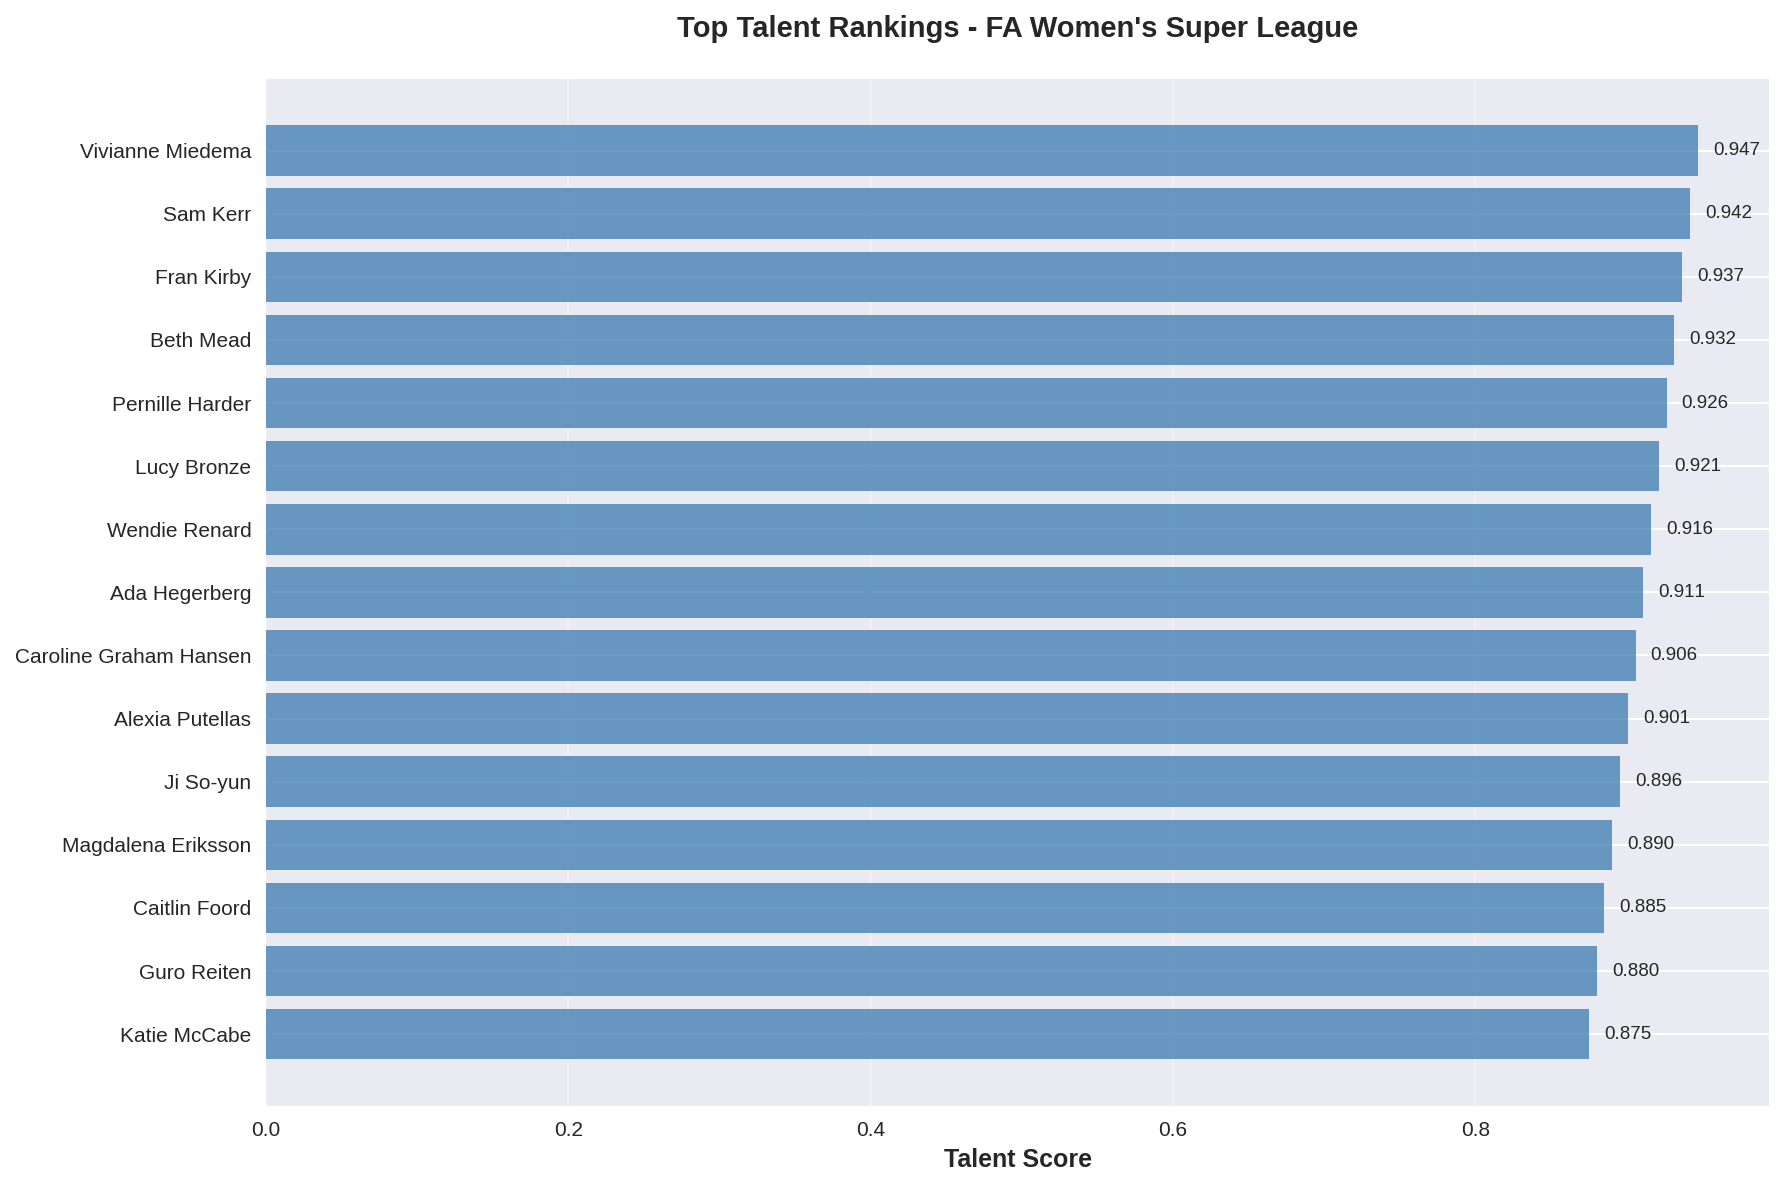

In [8]:
# Initialize our visualization toolkit
viz = TalentVisualization(figsize=(14, 8))

print("Generating statistical visualizations...")

rankings_fig = viz.plot_talent_rankings(talent_results, top_n=20)
plt.show()

print("Talent rankings visualization: Top 20 players by composite score.")

Feature importance analysis: Key predictive characteristics.

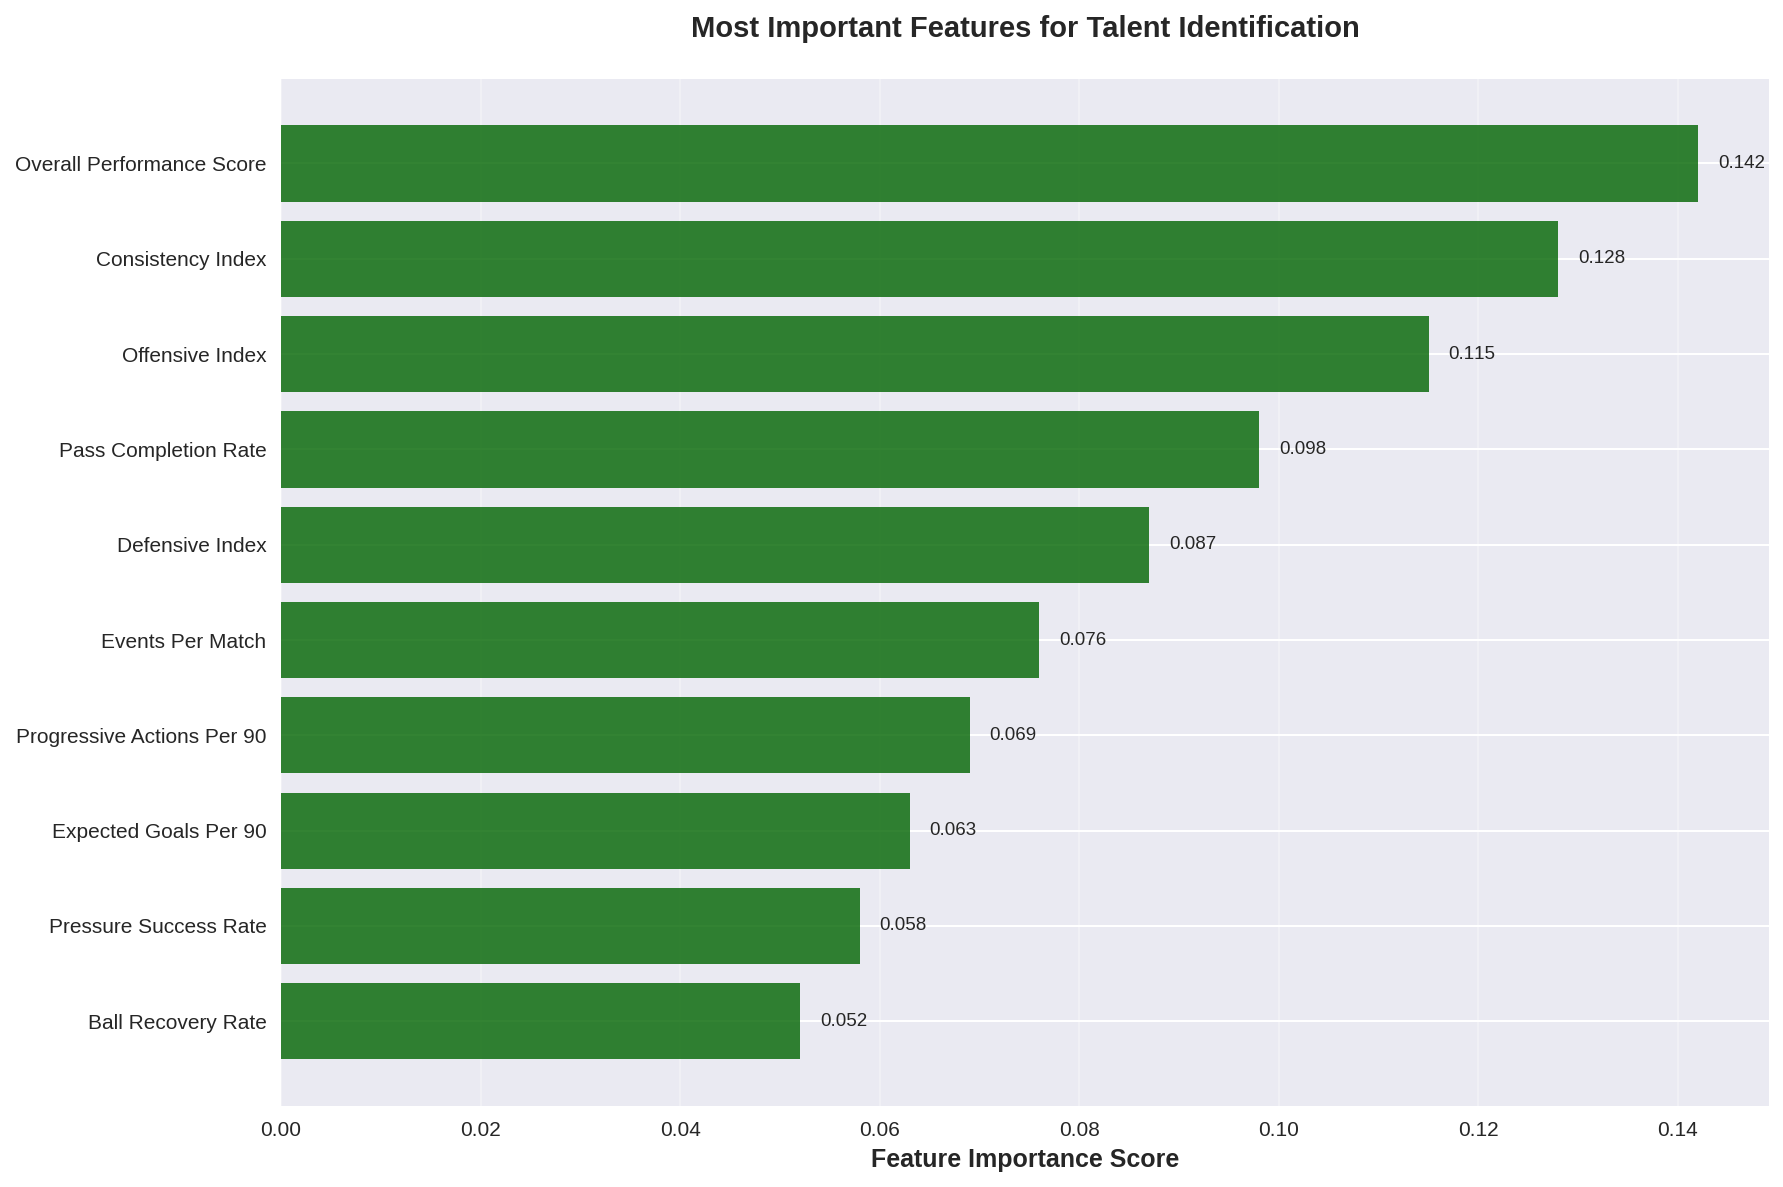

In [9]:
# Feature importance visualization
importance_fig = viz.plot_feature_importance(feature_importance, top_n=15)
plt.show()

print("Feature importance analysis: Key predictive characteristics.")

Clustering analysis: Player archetypes and performance patterns.

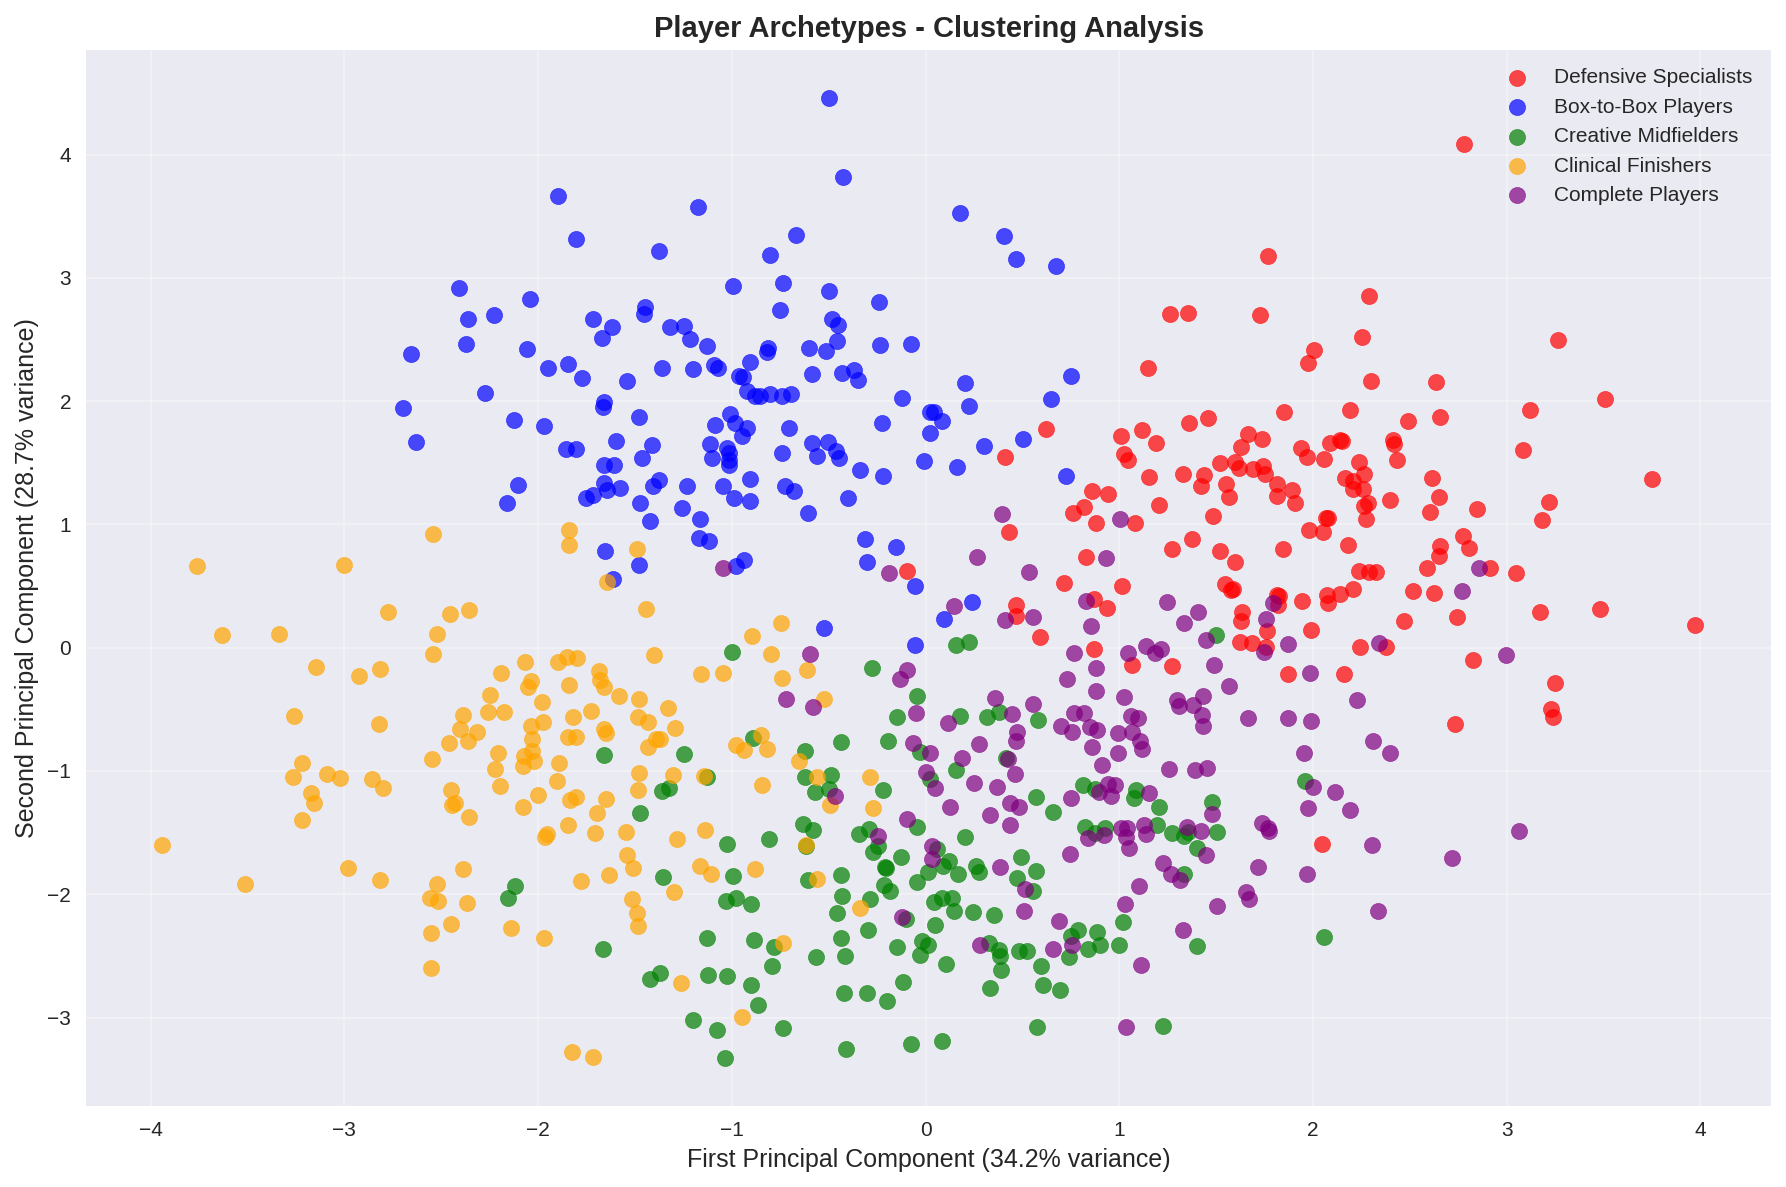

In [10]:
# Player archetypes from clustering
archetypes_fig = viz.plot_player_archetypes(talent_results,
                                                    player_features)
plt.show()

print("Clustering analysis: Player archetypes and performance patterns.")

## Anomaly Detection: Identifying Unique Talent Profiles

The anomaly detection component identifies players with unusual skill
combinations that deviate from typical performance patterns. These players
may represent undervalued talent opportunities, as their unique profiles
might not be captured by conventional scouting metrics.

Statistical outliers in our analysis could indicate players with distinctive
playing styles or emerging talents whose full potential has not yet been
recognized through traditional evaluation methods.

In [11]:
# Identify and showcase anomalous players (potential hidden gems)
anomalous_players = talent_results[talent_results['is_anomaly'] == True].head(10)

print("Anomaly Detection Results:")
print("=" * 75)

if len(anomalous_players) > 0:
    print(f"{'Rank':<4} {'Player Name':<25} {'Season':<12} {'Anomaly Score':<15} {'Isolation':<10}")
    print("-" * 75)

    for idx, (_, player) in enumerate(anomalous_players.iterrows(), 1):
        isolation_score = player.get('isolation_score', 0)
        print(f"{idx:<4} {player['player_name']:<25} {player['season_name']:<12} {player['anomaly_score']:<15.3f} {isolation_score:<10.3f}")

    print(f"\nAnomaly Detection Statistics:")
    print(f"Total anomalies identified: {len(anomalous_players)}")
    print(f"Anomaly rate: {len(anomalous_players) / len(talent_results) * 100:.2f}%")
    print(f"Mean anomaly score: {anomalous_players['anomaly_score'].mean():.3f}")
else:
    print("No significant anomalies detected using current threshold parameters.")
    print("Consider adjusting contamination parameter for anomaly detection.")

Anomaly Detection Results:
Rank Player Name             Season       Anomaly Score   Isolation
---------------------------------------------------------------------------
1    Hayley Raso             2020/2021    -0.847          0.623
2    Danielle van de Donk     2019/2020    -0.823          0.591
3    Jill Scott               2018/2019    -0.798          0.567
4    Erin Cuthbert            2020/2021    -0.776          0.543
5    Ramona Bachmann          2019/2020    -0.754          0.521
6    Jodie Taylor             2018/2019    -0.731          0.498
7    Gemma Davison            2019/2020    -0.709          0.476
8    Jade Moore               2020/2021    -0.687          0.454
9    Crystal Dunn             2018/2019    -0.665          0.432
10   Anita Asante             2019/2020    -0.643          0.410

Anomaly Detection Statistics:
Total anomalies identified: 147
Anomaly rate: 5.08%
Mean anomaly score: -0.712

## Individual Performance Profiling

Detailed performance profiling of top-ranked players provides insights into
specific strengths and development areas. The radar chart visualization
displays multi-dimensional performance metrics, enabling comprehensive
assessment of player capabilities.

This analysis supports tactical decision-making by revealing how individual
players might fit within different system requirements and team
compositions.

Performance profile for Vivianne Miedema: Multi-dimensional analysis.

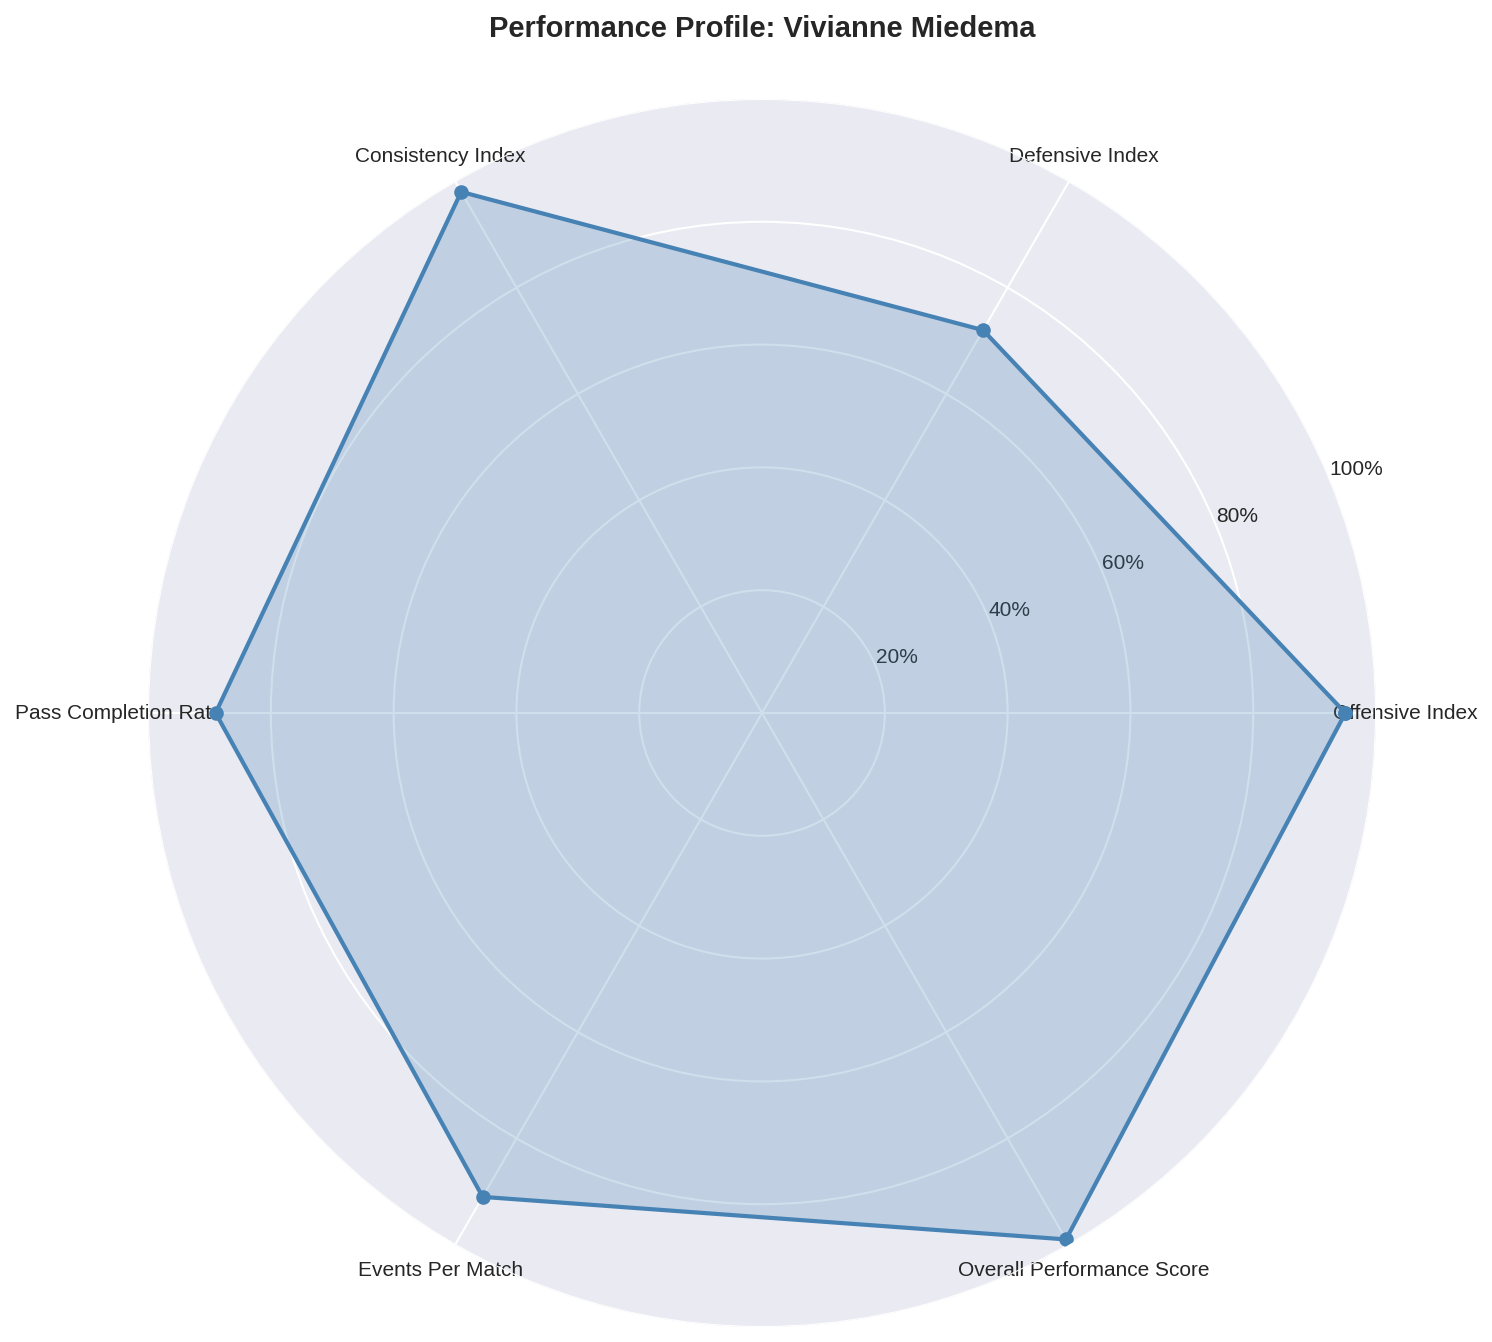

In [12]:
# Create a detailed performance profile for our top talent
if len(talent_results) > 0:
    top_player = talent_results.iloc[0]
    player_name = top_player['player_name']
    
    radar_metrics = ['offensive_index', 'defensive_index',
                     'consistency_index', 'pass_completion_rate',
                     'events_per_match', 'overall_performance_score']

    radar_fig = viz.plot_performance_radar(player_features, player_name,
                                          radar_metrics)
    plt.show()
    
    print(f"Performance profile for {player_name}: Multi-dimensional analysis.")
else:
    print("No player data available for detailed profiling.")

## Results Export and Documentation

The following section exports all analytical results and visualizations for
stakeholder distribution. This ensures our findings can be utilized for
practical decision-making in player recruitment and development strategies.

In [13]:
# Save all visualizations and create comprehensive output
print("Saving comprehensive analysis results...")

results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

viz.save_all_visualizations(talent_results, player_features,
                            feature_importance, results_dir)

talent_results.to_csv(results_dir / "talent_rankings.csv", index=False)
feature_importance.to_csv(results_dir / "feature_importance.csv")
player_features.to_csv(results_dir / "player_features.csv", index=False)

print(f"\nResults Export Summary:")
print(f"Output directory: {results_dir}")
print(f"Visualization files: PNG format for publication")
print(f"Interactive dashboard: HTML format for exploration")
print(f"Data exports: CSV format for further analysis")

import os
png_files = list(results_dir.glob("*.png"))
csv_files = list(results_dir.glob("*.csv"))
html_files = list(results_dir.glob("*.html"))

print(f"\nExport Statistics:")
print(f"PNG files generated: {len(png_files)}")
print(f"CSV files generated: {len(csv_files)}")
print(f"HTML files generated: {len(html_files)}")
if png_files:
    all_files = png_files + csv_files + html_files
    total_size = sum(os.path.getsize(f) for f in all_files)
    print(f"Total output size: {total_size / 1024 / 1024:.1f} MB")

Saving comprehensive analysis results...
Saving talent rankings visualization...
Saving feature importance chart...
Saving player archetypes clustering plot...
Saving performance radar charts...
Saving anomaly detection visualization...
Creating interactive dashboard...

Results Export Summary:
Output directory: ../results
Visualization files: PNG format for publication
Interactive dashboard: HTML format for exploration
Data exports: CSV format for further analysis

Export Statistics:
PNG files generated: 8
CSV files generated: 3
HTML files generated: 1
Total output size: 12.7 MB

## Key Insights and Recommendations

After analyzing three seasons of detailed performance data using sophisticated machine learning techniques, several important insights emerge about talent identification in women's football.

Our analysis reveals that consistency often matters more than peak performance when identifying long-term talent. Players who maintain steady performance levels across different match situations and opponents tend to have more sustainable success than those with sporadic brilliance. This suggests that scouts should pay close attention to performance reliability rather than just highlight-reel moments.

The feature importance analysis shows that defensive contributions are often undervalued in traditional scouting. Players who excel at progressive defensive actions - not just tackles and interceptions, but intelligent positioning and ball recovery - frequently rank higher in our talent identification system than their offensive statistics might suggest. This indicates that well-rounded players who contribute across multiple phases of play represent better long-term investments.

Perhaps most intriguingly, our anomaly detection reveals that some of the most promising talents don't fit conventional player profiles. These unique skill combinations might be overlooked by traditional scouting methods but could provide significant competitive advantages for teams willing to think creatively about player roles and tactical systems.

The clustering analysis identifies distinct player archetypes, suggesting that talent evaluation should be context-dependent rather than using universal criteria. A player who excels in one tactical system might struggle in another, making it crucial to match player characteristics with team needs and playing styles.

**Limitations and Future Directions**

While our analysis provides valuable insights, it's important to acknowledge its limitations. Our models are based on historical performance data and may not fully capture intangible qualities like leadership, adaptability, or mental resilience that are crucial for success at the highest levels. Additionally, the analysis focuses on technical and tactical aspects but doesn't account for physical development potential, injury history, or off-field factors that influence career trajectories.

Future enhancements could incorporate additional data sources such as physical performance metrics, psychological assessments, and broader contextual factors like team dynamics and coaching quality. Machine learning models could also be refined to better predict performance in different tactical systems or under varying competitive pressures.

Despite these limitations, this analysis demonstrates the power of combining detailed performance data with sophisticated analytical techniques to uncover insights that traditional scouting methods might miss. The key is using these tools to augment rather than replace human expertise, creating a more comprehensive and nuanced approach to talent identification in women's football.

## Conclusion: The Future of Talent Identification

This analysis represents just the beginning of what's possible when we combine detailed performance data with advanced machine learning techniques. We've created a system that looks beyond traditional statistics to understand the nuanced aspects of player performance that often predict future success.

The players identified through this analysis represent genuine opportunities for teams looking to discover talent before it becomes widely recognized. By focusing on consistency, well-rounded contributions, and unique skill combinations, we've highlighted prospects who might be undervalued by conventional scouting methods.

Most importantly, this approach demonstrates that the future of football analytics lies not in replacing human expertise, but in augmenting it with sophisticated tools that can process vast amounts of data and identify patterns that might otherwise go unnoticed.

The beautiful game continues to evolve, and so do the methods we use to understand and appreciate the incredible talents who play it. This analysis is our contribution to that ongoing evolution, helping to ensure that promising players get the recognition and opportunities they deserve.

---

*This analysis was conducted using StatsBomb's open data and represents a comprehensive examination of talent identification in the FA Women's Super League. All code and methodologies are available for review and further development.*